<hr style="border-width:4px;border-color:cyan" />
<hr style="border-width:2px;border-color:black" />

# Backward Euler with MPI
## ME471, Spring 2020, Final Project
### by Michael Elliott

<hr style="border-width:2px;border-color:black" />
<hr style="border-width:4px;border-color:cyan" />
<hr style="border-width:2px;border-color:black" />

    I was running this on Redhawk, but the nodes were limiting the number of CPUs that I could use and the cross node communication was doubling the time required to operate the same problem. I tested this situation by running the spots setup on 1 node, 4 processors on a 128 x 128 grid, and identical setup on 2 nodes. The 1 node version ran in 1 minute 28.4 seconds, while the 2 node version took slightly longer than 3 minutes 17 seconds. So I abandoned Redhawk for our trusty Virtual Machine, and this notebook will only cover results ran on the VM.
    A keen eye will notice that I'm hard coding in timing values for the arrays. This is not because I'm "just guessing the time" that these would take, rather I'm stuck hard coding it because the run took so long (~ 5 hours) and at 2 in the morning I didn't know exactly how to turn arrays into files to retain. I was anticipating that the VM would kick me off if my computer went to sleep so I took a screen shot of the timing results and hard coded it on my local machine. Not optimal use of technology but a broken clock is still right twice a day.
    
<hr style="border-width:2px;border-color:black" />
<hr style="border-width:4px;border-color:cyan" />

<hr style="border-width:4px;border-color:cyan" />
<hr style="border-width:2px;border-color:black" />

## Setup of Program and Data

    I ran this parallel backward Euler solver with the input setup for spots (from the homework 4 specifications) across square global grids of side lengths: 32, 64, 128, 256, and 512. These side lengths correspond to p values in the data (as in 2^p = N; p = 5 -> N = 32). It was ran using across a range of processors: 1, 2, 4, 8, and 16.
    
<hr style="border-width:2px;border-color:black" />
<hr style="border-width:4px;border-color:cyan" />

In [1]:
import matplotlib.pyplot
import scipy
import time, os
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# array setup section

#time_1proc[0] corresponds to 1 processor, p = 5
#time_1proc[1] corresponds to 1 processor, p = 6
#time_2proc[1] corresponds to 2 processors, p = 6
time_1proc = [2.45001602055,18.906493884,148.343905799,991.132974659,7628.0181528739]
time_2proc = [1.90655736811,10.254397049,79.552227533,471.779030761,3505.6236737109]
time_4proc = [2.49563256209,7.02648843382,40.542972475989,260.38621809,1764.485852355]
time_8proc = [2.17091187695,5.56852644495,19.158029562095,136.337621417,1020.692787826]
time_16proc = [3.0827721408,7.17792607215,13.148246705997,80.8943768569,621.719308567]

#p5_time[0] corresponds to timing results on 1 proc, p = 5 size grid
#p5_time[1] corresponds to timing results on 2 proc, p = 5 size grid
#pX_time's are strong scaling
p5_time = [2.450016102055,1.906557368114,2.49563256,2.17091187695,3.08277214086]
p6_time = [18.90649388405,10.25439704908,7.0264884338,5.568526444,7.17792607215]
p7_time = [148.343905799,79.5522275329,40.5429724759,19.158029562,13.14824670599]
p8_time = [991.1312974659,471.77903076,260.3862180931,136.337621416,80.894376857]
p9_time = [7628.018152873,3505.6236737109,1764.48585235,1020.692787826,621.719308567]

#weak_scale_time[0]: p5, 1 proc; [1]: p6, 2 proc; [2]: p7, 4 proc; [3]: p8, 8 procs; [4] p9, 16 procs
weak_scale_time = [time_1proc[0],time_2proc[1],time_4proc[2],time_8proc[3],time_16proc[4]]
plist = arange(5,10)
numproc = 2**arange(0,5)

#time_results is a linear version of the above information
time_results = []
for i in range(len(numproc)):
    time_results.append(time_1proc[i])
for i in range(len(numproc)):
    time_results.append(time_2proc[i])
for i in range(len(numproc)):
    time_results.append(time_4proc[i])
for i in range(len(numproc)):
    time_results.append(time_8proc[i])
for i in range(len(numproc)):
    time_results.append(time_16proc[i])

In [3]:
def fix_xticks(procs):
    p0 = log2(procs[0])
    p1 = log2(procs[-1])
    xlim([2**(p0-0.5), 2**(p1+0.5)])

    
    # Make nice tick marks
    pstr = (['{:d}'.format(int(p)) for p in procs])
    xticks(procs,pstr)

# does every other, for large processor setups
def fix_2xticks(procs):
    p0 = log2(procs[0])
    p1 = log2(procs[-1])
    xlim([2**(p0-0.5), 2**(p1+0.5)])
    numList = []
    i=0
    for p in procs:
        if (i%2 == 0):
            numList.append(p)
        i+=1
    pstr = (['{:d}'.format(int(n)) for n in numList])
    
    #xticks(procs,pstr)
    xticks(numList,pstr)

<hr style="border-width:4px;border-color:cyan" />
<hr style="border-width:2px;border-color:black" />

### Serial Behavior

    To run the code in serial, I still used MPI, but left the number of processors at 1. We see the expected relationship for the serial timings in the figure below.

<hr style="border-width:2px;border-color:black" />
<hr style="border-width:4px;border-color:cyan" />

([<matplotlib.axis.XTick at 0x11eb4ad10>,
 <a list of 5 Text xticklabel objects>)

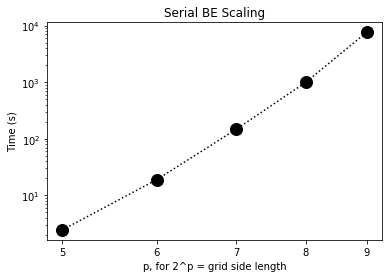

In [4]:
numproc = 2**arange(0,5)
line = arange(0,10,2)
m,b= polyfit(numproc,weak_scale_time,1)
figure(1)
clf()
ylabel("Time (s)")
xlabel("p, for 2^p = grid side length")
title("Serial BE Scaling")
loglog(plist, time_1proc,'ko:', markersize=12)
xticks(plist,[5,6,7,8,9])

<hr style="border-width:4px;border-color:cyan" />
<hr style="border-width:2px;border-color:black" />

### Weak Scaling

    We see in the weak scaling plot below that the parallel BE shows poor weak scaling. As we increase p and the number of processors together it scales just like the serial code, but with a little less of a slope. A quick estimation is a net time saving of about a factor of 10 for the parallel weak scaling over the serial code. Ideally, that black dotted line would be flat, showing that the time remains constant as we increase p and the number of processors each step. Why would this behavior happen for parallel BE? It could be my algorithm has some communication issues or inefficiencies, but I'm not sure. It's possible that the number of calculations required for a matrix, by the parallel BE algorithm, has an associated constant factor. As we increase the matrix size, this factor grows causing the calculation time to increase at aconstant rate for BE.

<hr style="border-width:2px;border-color:black" />
<hr style="border-width:4px;border-color:cyan" />

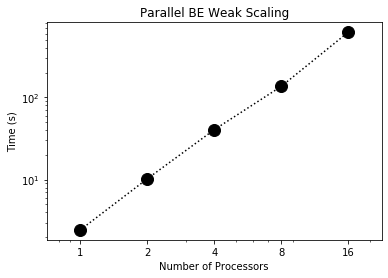

In [5]:
numproc = 2**arange(0,5)
line = arange(0,10,2)
figure(2)
clf()
ylabel("Time (s)")
xlabel("Number of Processors")
title("Parallel BE Weak Scaling")
loglog(numproc,weak_scale_time,'ko:', markersize=12)
fix_xticks(numproc)

<hr style="border-width:4px;border-color:cyan" />
<hr style="border-width:2px;border-color:black" />

### Strong Scaling

We see in the strong scaling plot below that the parallel BE shows very good strong scaling for the larger grid sizes. A linear best fit line shows slopes of -44 for p = 8, and -338 for p = 9 which is reflected in the significant time improvements for p = 8 and p = 9 grids. For smaller grid sizes, the scaling is much flatter. I'm assuming that this is related to the simplicity of a 32 x 32 grid for this problem. A small grid would require lots of processor communication with few calculations thus not maximizing time actually on the processor.

<hr style="border-width:2px;border-color:black" />
<hr style="border-width:4px;border-color:cyan" />

m = -338.31 for linear best fit, p = 9


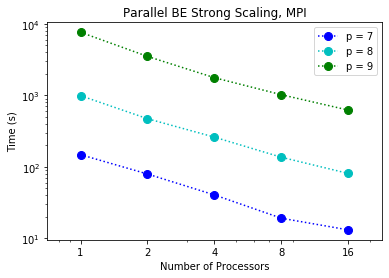

In [6]:
numproc = 2**arange(0,5)
line = arange(0,10,2)
m,b= polyfit(numproc,p9_time,1)
figure(3)
clf()
#ylim((1,5))
ylabel("Time (s)")
xlabel("Number of Processors")
title("Parallel BE Strong Scaling, MPI")
#loglog(numproc,(m*numproc+b),label = "Best fit line, p = 9, m: %0.3f"%m)
#loglog(numproc, p5_time,'ko:', markersize=8, label="p = 5")
#loglog(numproc, p6_time,'ro:', markersize=8, label="p = 6")
loglog(numproc, p7_time,'bo:', markersize=8, label="p = 7")
loglog(numproc, p8_time,'co:', markersize=8, label="p = 8")
loglog(numproc, p9_time,'go:', markersize=8, label="p = 9")
legend()
fix_xticks(numproc)
print("m = %0.2f for linear best fit, p = 9"%m)

<hr style="border-width:4px;border-color:cyan" />
<hr style="border-width:2px;border-color:black" />

### Efficiency

Even at the highest grid size, 512 x 512, we see incredible efficiency for this algorithm and calculation. As we've mentioned before, the Virtual Machine's parallel behavior is unknown/inconsistant around 16 processors. Even with the possible threading behavior at 16 processors we see an efficiency of near 80% which is very good. For 2 processors and 4 processors we even see an efficiency over 100%, with 8 processors coming in above 90% as well. All in all, I think this implicit scheme seems well suited to "strong parallelization", but for large matrices, the weak scaling may dictate that a different algorithm should be sought.

<hr style="border-width:2px;border-color:black" />
<hr style="border-width:4px;border-color:cyan" />

In [7]:
pAdj = 4 # pAdj=0 -> p = 5; pAdj=1 -> p = 6; pAdj=2 -> p = 7; pAdj=3 -> p = 8; pAdj=4 -> p = 9
speed_up = []
for i in range(len(numproc)): 
    speed_up.append(time_results[pAdj]/time_results[pAdj+i*len(numproc)])
efficiency = []
for i in range(len(numproc)):
    efficiency.append(100*speed_up[i]/numproc[i])

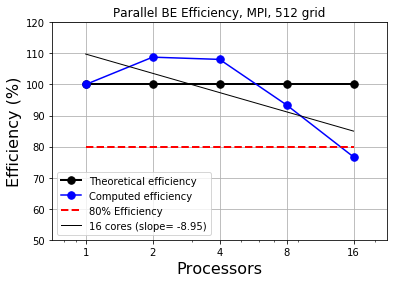

In [8]:
figure(4)
clf()
title("Parallel BE Efficiency, MPI, 512 grid")
hundred = [100,100,100,100,100]
eighty = [80,80,80,80,80]

semilogx(numproc,hundred,'k.-',markersize=15,linewidth=2,label='Theoretical efficiency')

semilogx(numproc,efficiency,'.-',color='b',markersize=15,label='Computed efficiency')


# Let's also add a line indicating "good" efficiency.
semilogx(numproc,eighty,'r--',markersize=15,linewidth=2,label='80% Efficiency')
# Add a best-fit line through first few cores.
t_eff = efficiency

# Fit line through all 16 cores
proc_max = 16    # number of processors on VM, supposedly
imax = int(log2(proc_max))+1 
c = polyfit(log(numproc[:imax]),t_eff[:imax],1)
semilogx(numproc,polyval(c,log(numproc)),'k-', \
         label='{:d} cores (slope={:6.2f})'.format(proc_max,c[0]),linewidth=1)


fix_xticks(numproc)
ylim(50,120)
xlabel('Processors',fontsize=16)
ylabel('Efficiency (%)',fontsize=16)
legend(loc=3)
grid()

In [13]:
figure(1)
savefig('serial.png', facecolor=None, edgecolor=None,
        format='png',transparent=False, bbox_inches='tight', pad_inches=0.1,metadata=None)

figure(2)
savefig('weakScaling.png', facecolor=None, edgecolor=None,
        format='png',transparent=False, bbox_inches='tight', pad_inches=0.1,metadata=None)

figure(3)
savefig('strongScaling.png', facecolor=None, edgecolor=None,
        format='png',transparent=False, bbox_inches='tight', pad_inches=0.1,metadata=None)

figure(4)
savefig('efficiency.png', facecolor=None, edgecolor=None,
        format='png',transparent=False, bbox_inches='tight', pad_inches=0.1,metadata=None)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<hr style="border-width:4px;border-color:cyan" />
<hr style="border-width:2px;border-color:black" />

## Visuals

<hr style="border-width:3px;border-color:cyan" />
<hr style="border-width:2px;border-color:black" />
<hr style="border-width:3px;border-color:cyan" />

#### Spots 256 grid 
![](spots8.gif)

<hr style="border-width:3px;border-color:cyan" />
<hr style="border-width:2px;border-color:black" />
<hr style="border-width:3px;border-color:cyan" />

#### Stripes 512 grid

![](3proc512_8_stripes_long.gif)

<hr style="border-width:3px;border-color:cyan" />
<hr style="border-width:2px;border-color:black" />
<hr style="border-width:3px;border-color:cyan" />

#### In Between Conditions 256 grid

![](128_8_in4Between.gif)

<hr style="border-width:3px;border-color:cyan" />
<hr style="border-width:2px;border-color:black" />
<hr style="border-width:3px;border-color:cyan" />

![](128_8_inBetween.gif)

<hr style="border-width:3px;border-color:cyan" />
<hr style="border-width:2px;border-color:black" />
<hr style="border-width:3px;border-color:cyan" />

![](128_8_in2Between.gif)

<hr style="border-width:4px;border-color:cyan" />
<hr style="border-width:2px;border-color:black" />